### 고객의 행동을 '예측'

이 장에서는 앞서 사전 분석한 스포츠 센터 회원의 행동 정보를 이용해서 머신러닝으로 예측합니다. 회원의 행동은 이용 빈도 등에 따라 경향이 크게 달라집니다. 그래서 군집화(클러스터링)라는 기법을 이용하면 회원을 군집화할 수 있고 각 그룹의 행동 패턴을 파악함으로써 미래 예측의 정확도를 높이는 것이 가능해집니다.

고객의 소리) 지난번 분석으로 어느 정도 경향을 파악할 수 있엇습니다. 아직 전체적인 경향밖에 파악하지 못해서 이번에는 좀 더 구체적인 분석을 부탁드리려고 합니다. 고객별로 이용 경향이 다르기 때문에 이런 경향을 분석해서 고객별 이용 횟수 같은 것도 예측할 수 있지 않을까 라는 생각이 듭니다. 이런 분석도 가능할까요?

- feature : 고객 경향
- target : 고객별 이용 횟수

데이터셋)
1. use_log.csv : 센터 이용 이력(회원이 센터를 이용하면 시스템에 자동 입력 - 2018년 4월 ~ 2019년 3월의 1년분 데이터)     
2. customer_master.csv : 2019년 3월 말 시점의 회원 데이터(이전에 탈퇴한 회원 포함)             
3. class_master.csv : 회원 구분 데이터(종일, 주간, 야간)           
4. campaign_master.csv : 가입 시 행사 종류 데이터(입회비 유무 등)       
5. customer_use_merge_df.csv : 이전에 작성한 <b><u>이용 이력을 포함한 고객 데이터</u></b>        

-> 이 중 use_log.csv와 customer_use_merge_df.csv만 사용 예정

* mean, median, max, min : 고객 월 이용 횟수
* regularity : 고객 월,요일 이용 횟수 > 4일 경우 1, 아닌 경우 0

In [2]:
import pandas as pd 

use_log = pd.read_csv('./data/1장/use_log.csv')
use_log.head()

total_customer = pd.read_csv('./data/1장/customer_use_merge_df.csv')
total_customer.head()

# 결측치 확인
use_log.isnull().sum()
total_customer.isnull().sum()

# mean, median, max, min : 고객 월 이용 횟수
# regularity : 고객 월,요일 이용 횟수 > 4일 경우 1, 아닌 경우 0

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
regularity              0
calc_date               0
membership_period       0
dtype: int64

>> 고객 데이터 그룹화

- 이용 이력을 이용한 그룹화(클러스터링)
- 정해진 정답이 없기에 비지도 학습 클러스터링 이용

In [3]:
# 클러스터링에 이용하는 변수 : mean, median, max, min, membership_period(고객의 한 달 이용 이력 데이터)

customer_for_cluster = total_customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_for_cluster.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


>> K-Means(변수 간의 거리 기반 그룹화)

- mean, median, max, min : 1~8 사이의 값
- membership_period : 최댓값이 47           
-> 표준화 필요

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

std_scaler = StandardScaler()
customer_for_cluster_scaled = std_scaler.fit_transform(customer_for_cluster)

kmeans = KMeans(n_clusters= 4, random_state= 0)

# fit > .lables
clusters = kmeans.fit(customer_for_cluster_scaled)
clusters.labels_[4100:] # 3번 cluster
clusters.labels_[:10] # 2번 cluster

customer_for_cluster['cluster'] = clusters.labels_
customer_for_cluster['cluster'].unique() # 0~3
customer_for_cluster.head()

# # fit_transform > ndarray
# clusters = kmeans.fit_transform(customer_for_cluster_scaled) # X_new return (n_samples, n_clusters)
# clusters # (4192, 4)
# clusters[4100:] # 3번 cluster(거리 가장 작은)
# clusters[:10] # 2번 cluster
# # fit_transform은 행 : n_samples, 열 : n_cluster와의 거리

C:\Users\LGCARE\AppData\Local\Temp\ipykernel_22124\3937401102.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_for_cluster['cluster'] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


In [5]:
customer_for_cluster.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원 기간', 'cluster']
customer_for_cluster.head()

customer_for_cluster.groupby(by= 'cluster').count() # 결과가 책과 다름

,월평균값,월중앙값,월최댓값,월최솟값,회원 기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,771,771,771,771,771
2,1249,1249,1249,1249,1249
3,838,838,838,838,838


>> 클러스터별 평균값

In [6]:
customer_for_cluster.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원 기간,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


In [7]:
customer_for_cluster.groupby(by= 'cluster').mean()

# 그룹 1 : 회원 기간이 짧고 이용률이 가장 낮은 회원
# 그룹 3 : 회원 기간은 짧지만 이용률이 가장 높은 회원
# 그룹 0과 그롭 2 : 회원 기간이 상대적으로 긴 회원
# 그룹 0과 그룹 2를 비교하면 그룹 2가 회원 기간은 길지만 이용률이 약간 낮습니다.

,월평균값,월중앙값,월최댓값,월최솟값,회원 기간
cluster,,,,,
0,5.541974,5.392804,8.757871,2.704648,14.857571
1,3.065504,2.900130,4.783398,1.649805,9.276265
2,4.677561,4.670937,7.233787,2.153723,36.915933
3,8.064079,8.050716,10.014320,6.180191,7.016706


>> 클러스터링 결과 가시화

- 클러스터링에 사용한 변수 5개

<b><u>5개의 변수를 2차원으로 그리기 위해 차원을 축소</u></b>합니다. 차원 축소란 비지도학습의 일종으로 정보를 되도록 잃지 않게 하면서 새로운 축을 만드는 것입니다. 이렇게 하면 5개의 변수를 2개의 변수로 표현할 수 있고 그래프로도 그릴 수 있습니다. 여기서는 차원 축소의 대표적인 방법인 주성분 분석을 사용합니다.
이 때, 주성분 분석에는 위에서 사용한 표준화 데이터를 사용합니다.

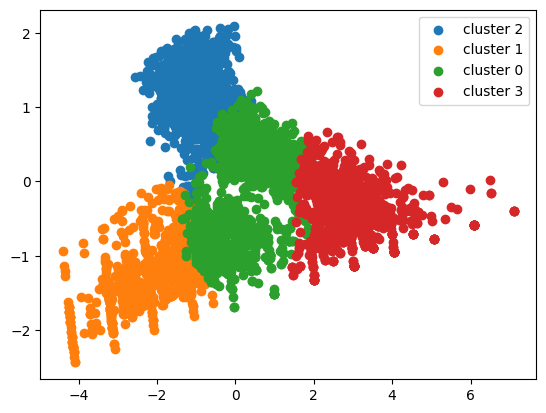

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components= 2, random_state= 0)

X = customer_for_cluster_scaled # (4192, 5)
X

X_pca = pca.fit_transform(X) # (x1, x2)

pca_df = pd.DataFrame(X_pca)
pca_df['cluster'] = clusters.labels_ # (x1, x2, cluster)

for i in pca_df['cluster'].unique() :
  tmp = pca_df[pca_df['cluster'] == i]
  label = f'cluster {i}'
  plt.scatter(tmp[0], tmp[1], label = label)

plt.legend()


>> 클러스터링 + 차원 축소 요약

C:\Users\LGCARE\AppData\Local\Temp\ipykernel_22124\1605424068.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_customer_stats['cluster'] = clusters.labels_ # (x1, x2, cluster)


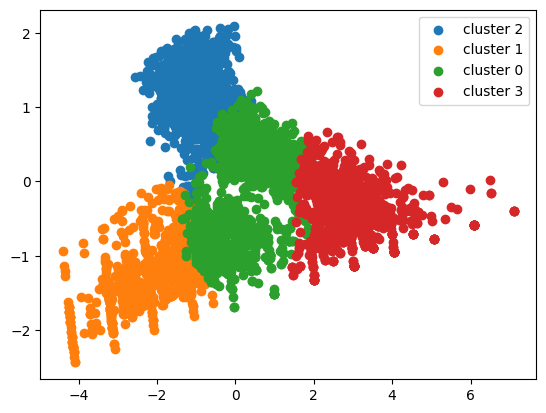

In [9]:
# 요약)

# 클러스터링)
total_customer_stats = total_customer[['mean', 'median', 'max', 'min', 'membership_period']]

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

total_customer_stats_scaled = std_scaler.fit_transform(total_customer_stats) # array 반환

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 4, random_state= 0)

X = total_customer_stats_scaled # (4192, 5)
clusters = kmeans.fit(total_customer_stats_scaled)
# fit_transform > 각 cluster와의 거리값 arr 반환

total_customer_stats['cluster'] = clusters.labels_ # (x1, x2, cluster)
total_customer_stats.head()

# 클러스터별 통계
total_customer_stats.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원 기간', 'cluster']
total_customer_stats.groupby(by= 'cluster').mean()

# 클러스터링 가시화 
# 1) 5개의 변수 > 2개로 차원 축소
# 2) 클러스터별 산점도(2개의 변수)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components= 2, random_state= 0)

X_pca = pca.fit_transform(total_customer_stats_scaled) # (PC1, PC2) : 기존 변수의 선형 결과
X_pca

X_pca_df = pd.DataFrame(X_pca)
X_pca_df['cluster'] = clusters.labels_ 
X_pca_df

# for문을 통해 그룹마다 다른 색깔로 scatter
for i in X_pca_df['cluster'].unique() :
  coordinate = X_pca_df[X_pca_df['cluster'] == i] # [0] : PC1, [1] : PC2, [2] : cluster
  label = f'cluster {i}'
  plt.scatter(coordinate[0], coordinate[1], label = label)

plt.legend()
plt.show()

- 깨끗하게 색깔이 나뉘어 있어 정보를 보존한 채 깔끔하게 축소된 것을 확인
- 일반적으로 작성한 2개의 축(변수)이 어떤 변수로 구성되는지를 분석해서 파악
- X축(PC1)이 클수록 -> 월 평균/중앙/최대/최소 사용량이 높은 고객
- y축(PC2)이 클수록 -> 회원 기간이 긴 고객

5개의 변수 > 2개의 변수로 차원 축소한 PC1, PC2는 기존 변수의 <b><u>선형 결합</u></b>           
따라서, 어떤 기존 변수와 관련이 깊은지 파악하려면 PCA의 성분 개수(components)를 파악해야 함

In [10]:
pca_components_df = pd.DataFrame(
  pca.components_,
  columns= ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원 기간'],
  index=['PC1', 'PC2']
)

print(pca_components_df)
# PC1은 네 가지 변수가 모두 양의 방향으로 '고르게' 영향을 줌 
# / 반면 회원 기간(-0.19)는 약간 반대 방향(음의 방향)으로 작게 기여

# PC2는 회원 기간(0.9451)이 압도적으로 큰 양의 값
# / 나머지는 다 미미하거나 영향 거의 없음

# > PC1은 '사용량 수준 전반'을 대표하는 축
# > PC2는 '회원 기간'을 주로 반영하는 축
print(pca.explained_variance_ratio_)

# [0.69042666 0.18937526]
# PC1이 전체 분산의 약 69%를 설명하고
# PC2가 추가로 19%를 설명
# 총 약 88%의 정보를 보존

         월평균값      월중앙값      월최댓값      월최솟값     회원 기간
PC1  0.532650  0.513845  0.441831  0.470014 -0.190050
PC2  0.109719  0.149198  0.236745 -0.127829  0.945153
[0.69042666 0.18937526]


>> 클러스터링 결과를 활용한 탈퇴 회원의 경향

지속 회원/탈퇴 회원이 '어느' 클러스터링된 집단에 속할지 집계

In [11]:
# # 실습)

# customer_for_cluster['is_deleted'] = total_customer['is_deleted']
# customer_for_cluster.head()

# customer_for_cluster.groupby(by= ['cluster', 'is_deleted'], as_index= False).count()['월평균값']
# customer_for_cluster.pivot_table(values= '월중앙값', index= 'cluster', columns= 'is_deleted', aggfunc= 'count')

In [12]:
# 책)
customer_for_cluster = pd.concat([customer_for_cluster, total_customer], axis= 1)
customer_for_cluster.head()

customer_for_cluster.groupby(by=['cluster', 'is_deleted'], as_index= False).count()[['cluster', 'is_deleted', 'customer_id']]

# customer_for_cluster과 total_customer는 index로 연결되어 있어 concat으로 결합 가능
# 결과)
# 그룹 0은 탈퇴 회원, 지속 회원이 고르게 분포
# 그룹 1은 탈퇴 회원만 있고
# 그룹 2,3은 지속 회원이 많음

# 클러스터링 시각화 참고했을 때(2개로 축소한)
# 그룹 1은 월이용률이 낮고 회원 기간이 짧은 집단
# 그룹 2,3은 월이용률이 보통-많고 회원 기간도 보통인 집단(집단 3이 이용률이 더 큼)

,cluster,is_deleted,customer_id
0,0,0,791
1,0,1,543
2,1,1,771
3,2,0,1231
4,2,1,18
5,3,0,820
6,3,1,18


In [13]:
# 클러스터링 집계 참고했을 때
customer_for_cluster.groupby(by= 'cluster', as_index= False)[['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원 기간']].mean()

# 그룹 0 : 전반적으로 무난(중간에 위치)
# 그룹 1 : 이용률이 낮고 회원 기간이 짧은 집단
# 그룹 2 : 이용률이 그룹 3보다는 낮지만 회원 기간이 길고 지속 회원이 많아 이용이 안정적
# 그룹 3 : 회원 기간이 짧지만 초기에 의욕이 높아 전체적인 이용률이 높은 집단

# 그룹 0, 2 : 회원 기간이 긴 집단, 월이용률 무난
# 그룹 1 : 회원 기간이 짧고 이용류롣 낮은 집단
# 그룹 3 : 회원 기간이 짧지만 이용률이 높은 집단

,cluster,월평균값,월중앙값,월최댓값,월최솟값,회원 기간
0,0,5.541974,5.392804,8.757871,2.704648,14.857571
1,1,3.065504,2.900130,4.783398,1.649805,9.276265
2,2,4.677561,4.670937,7.233787,2.153723,36.915933
3,3,8.064079,8.050716,10.014320,6.180191,7.016706


>> 정기적/비정기적 이용 여부

In [14]:
customer_for_cluster.groupby(by= ['cluster', 'regularity'], as_index= False).count()[['cluster', 'regularity', 'customer_id']]

# 집단 0, 2, 3 : 정기적 이용
# 집단 1 : 비정기적 이용

# 집단 0, 2 : 지속 회원이 많은 그룹 + 정기적 이용

,cluster,regularity,customer_id
0,0,0,227
1,0,1,1107
2,1,0,499
3,1,1,272
4,2,0,2
5,2,1,1247
6,3,0,51
7,3,1,787


지금까지의 분석에서도 회원의 이용 방법(행동)이 중요하다는 것을 알 수 있었습니다. 다음으로 회원의 과거 행동 데이터로부터 다음 달 이용 횟수 예측하기에 도전해 봅시다.

>> 이용 횟수 예측 모델

- 지도학습의 회귀 분석
- 과거 6개월의 이용 데이터를 사용해 다음 달의 이용 횟수를 예측

이번 달 : 2018년 10월          
예측 : 2018년 11월의 이용 횟수            

학습 데이터 : 2018년 5월~10월까지 6개월의 이용 데이터           
정답 데이터 : 2018년 11월의 이용 횟수

데이터 준비)              
학습 데이터 : 201811-201903 시점별 기준 직전 6개월의 이용 데이터           
정답 데이터 : 201811-201903 이용 횟수

In [ ]:
use_log['usedate'] = pd.to_datetime(use_log['usedate'])
use_log['use_month'] = use_log['usedate'].dt.strftime('%Y%m')
use_log.head()

,log_id,customer_id,usedate,use_month
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [ ]:
monthly_use_df = use_log.groupby(by= ['customer_id', 'use_month'], as_index= False).count()[['customer_id', 'use_month', 'log_id']]
monthly_use_df.rename(columns= {'log_id' : 'count'}, inplace= True)

# 201811-201903 각 시점별 직전 6개월 데이터와 병합한 데이터프레임
# DataFrame > year_month  | customer_id | count_pred | count_0 ~ 5(월별 count)
total_period = use_log['use_month'].unique()
total_period

data_ml = pd.DataFrame()

for i in range(6, len(total_period)) :
  # i : target_period를 순회
  tmp = monthly_use_df.loc[monthly_use_df['use_month'] == total_period[i]]
  tmp.rename(columns= {'count' : 'count_pred'}, inplace= True)
  for j in range(1, 7) :
    # j : target_month 기준 직전 6개월
    tmp_before = monthly_use_df.loc[monthly_use_df['use_month'] == total_period[i - j]] # 직전 1개월-직전 6개월
    tmp_before.rename(columns = {'count' : f'count_{j-1}'}, inplace= True)
    tmp_before.drop('use_month', axis= 1, inplace= True)
    tmp = tmp.merge(tmp_before, on= 'customer_id', how= 'left') # j문이 다 돌면 한 시점 기준의 직전 6개월의 customer_id | use_month | count_0-5 데이터프레임 생성
    # print(tmp) # index 확인용 > merge할 때 index 자동으로 reset_index
  data_ml = pd.concat([data_ml, tmp], ignore_index= True) # 위아래로 병합 > i문이 다 돌면 목표 시점별 직전 6개월의 데이터가 세로로 결합

data_ml.head()


C:\Users\LGCARE\AppData\Local\Temp\ipykernel_22124\3064027632.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.rename(columns= {'count' : 'count_pred'}, inplace= True)
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_22124\3064027632.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {'count' : f'count_{j-1}'}, inplace= True)
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_22124\3064027632.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,customer_id,use_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,AS002855,201810,3,7.0,3.0,5.0,5.0,5.0,4.0
1,AS008805,201810,2,2.0,5.0,7.0,8.0,NaN,NaN
2,AS009373,201810,5,6.0,6.0,7.0,4.0,4.0,3.0
3,AS015233,201810,7,9.0,11.0,5.0,7.0,7.0,NaN
4,AS015315,201810,4,7.0,3.0,6.0,3.0,3.0,6.0


In [16]:
# # 데이터 준비
# # 연월, 회원마다 사용 로그 집계
# use_log['usedate'] = pd.to_datetime(use_log['usedate'])
# use_log['use_month'] = use_log['usedate'].dt.strftime('%Y%m')
# use_log['use_month'].head()

# ym_use_log = use_log.groupby(by= ['use_month', 'customer_id'], as_index= False).count()[['use_month', 'customer_id', 'log_id']]
# ym_use_log.rename(columns= {'log_id' : 'count'}, inplace= True)
# ym_use_log

# # 2018년 04월부터 2018년 10월까지 > 과거 6개월분의 이용 횟수 / 다음 달(2018년 11월)의 이용 횟수를 저장
# # DataFrame > year_month  | customer_id | count_pred | count_0 ~ 5(월별 count)



In [17]:
# # 과거부터 201804-201809 , 201805-201810, 201806-201811

# use_count = use_log.groupby(by= ['use_month', 'customer_id'], as_index= False).count()[['customer_id', 'use_month', 'log_id']].rename(columns= {'log_id' : 'count'})
# year_months = list(use_count['use_month'].unique())

# predict_data = pd.DataFrame()

# for i in range(6, len(year_months)) : # 201810부터 직전 6개월 데이터 존재 > i : 201810-201903
#   tmp_df = use_count.loc[use_count['use_month'] == year_months[i]]
#   tmp_df.rename(columns={'count' : 'count_pred'}, inplace= True)

#   for j in range(1, 7) :
#     tmp_before = use_count.loc[use_count['use_month'] == year_months[i - j]] # i=6 > j=5~0, i=7 > j=6~1
#     del tmp_before['use_month']
#     tmp_before.rename(columns= {'count' : 'count_{}'.format(j-1)}, inplace= True) # 201809: 0, 201804 : 5
#     tmp_df = pd.merge(tmp_df, tmp_before, on= 'customer_id', how= 'left') # i=6, j=1 > tmp_df = 201810_df + 201804_df
#                                                                           # i=6, j=2 > tmp_df = 201810_df + 201804_df + 201805_df, ,,
#                                                                           # i=6, j=6 > tmp_df = 201810_df + 201804_df + 201805_df + ,, + 201809_df
#                                                                           # i=7, j=1 > tmp_df = 201811_df + 201805_df
#                                                                           # ,,
#                                                                           # i=12, j=1 > tmp_df = 201903_df + 201810_df _ ,,
  
#   predict_data = pd.concat([predict_data, tmp_df], ignore_index= True)

# predict_data.info()
# predict_data.head()

>> X

In [18]:
# # 201811기준 직전 6개월 데이터프레임 코드

# # 1)
# total_use_month = ym_use_log['use_month'].sort_values().unique() # 201804 - 201903
# target_period = total_use_month[0:7] # array([['201804' '201805' '201806' '201807' '201808' '201809' '201810']])
# print(target_period)

# # 챗gpt)

# for i, month in enumerate(target_period):
#     if i < 6:
#         continue  # 과거 6개월이 안 쌓이면 스킵
#     past_months = target_period[i-6:i]  # 201804부터 201809 - 6개월
#     print(past_months)
#     next_month = month  # 예측 달(201811)

#     # 과거 6개월 데이터
#     past_data = ym_use_log[ym_use_log['use_month'].isin(past_months)].copy() # use_month, customer_id, count

#     # 다음달 데이터
#     next_data = ym_use_log[ym_use_log['use_month'] == next_month].copy()  # use_month, customer_id, count
#     next_data = next_data.rename(columns={'count': 'count_pred'})   # use_month, customer_id, count_pred
    
#     # pivot | pivot_table : 집계원할 때
#     past_pivot = past_data.pivot(index='customer_id', columns='use_month', values='count') # customer_id, 201804, ,, 201809
#     past_pivot = past_pivot.reset_index()
#     past_pivot_columns = ['customer_id']
#     past_pivot_columns.extend([f'count_{5-j}' for j in range(6)]) # 최근부터 과거 0~5 > 201804가 5
#     past_pivot.columns = past_pivot_columns

#     # merge
#     merged = pd.merge(next_data, past_pivot, on='customer_id', how='left') # use_month, customer_id, count_pred, 201804, ,, 201809
#     # print(merged)

# use_log_6month = pd.DataFrame(merged)
# use_log_6month

# # 열 순서 정리
# use_log_6month = use_log_6month[['use_month', 'customer_id', 'count_pred', 'count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5']]

# use_log_6month.head()

# # 실습)
# # 201804 - 201809 : 학습
# # 201811 : 예측

# use_count = use_log.groupby(by= ['use_month', 'customer_id'], as_index= False).count()[['customer_id', 'use_month', 'log_id']].rename(columns= {'log_id' : 'count'})
# use_count

# total_month = use_count['use_month'].unique()[0:7]
# print(total_month)

# for i in range(len(total_month)) :
#   if i < 6 :
#     continue
#   past_month = total_month[:i]
#   # print(past_month)
#   target_month = total_month[i]
#   # print(target_month)

#   past_month_df = use_count.loc[use_count['use_month'].isin(past_month)]
#   # print(past_month_df)
#   target_month_df = use_count.loc[use_count['use_month'] == target_month]
#   # print(target_month_df)

#   past_month_pivot = past_month_df.pivot(index= 'customer_id', columns= 'use_month', values= 'count') # 201804 - 201809까지 열 순서대로
#   past_month_pivot.reset_index(inplace= True) # customer_id가 col로
#   past_month_pivot_cols = ['customer_id']
#   past_month_pivot_cols.extend([f'count_{5-j}' for j in range(6)]) # 201804에 count_5부여
#   past_month_pivot.columns = past_month_pivot_cols

#   use_count_6month = pd.merge(left= target_month_df, right= past_month_pivot, how= 'left', on= 'customer_id')
#   use_count_6month.rename(columns= {'count' : 'count_pred'}, inplace= True)

# use_count_6month = use_count_6month[['use_month', 'customer_id', 'count_pred','count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5']]
# use_count_6month.head()
# use_count_6month.info()